In [1]:
# Import modules
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
# Set seed
np.random.seed(42)

/Users/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load generated data
# Rows : time point / columns : neurons states
neuron_data = np.load('stochastic_out.npy')

In [3]:
# Split into training and test sets
# Train on 700 of the 1000 time steps
n_train_steps = 700

train = neuron_data[:n_train_steps, :]
test = neuron_data[n_train_steps:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, :-1]
test_X, test_y = test[:, :-1], test[:, :-1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(700, 1, 999) (700, 999) (301, 1, 999) (301, 999)


## Create model (LSTM: Long Short Term Memory)

In [4]:
# Custom made loss function for highly unbalanced 2D data (lots of 0)
# Credit: https://stackoverflow.com/questions/46632225/keras-lstm-for-timeseries-prediction-predicting-vectors-of-features
import keras.backend as K

def weightedByBatch(yTrue,yPred):

    nVec = K.ones_like(yTrue) #to sum the total number of elements in the tensor
    percent = K.sum(yTrue) / K.sum(nVec) #percent of ones relative to total
    percent2 = 1 - percent #percent of zeros relative to total   
    yTrue2 = 1 - yTrue #complement of yTrue (yTrue+ yTrue2 = full of ones)   

    weights = (yTrue2 * percent2) + (yTrue*percent)
    return K.mean(K.binary_crossentropy(yTrue,yPred)/weights)

In [5]:
USE_CUSTOM_LOSS = True

Train on 700 samples, validate on 301 samples
Epoch 1/50
 - 1s - loss: 9.0421 - val_loss: 7.5322
Epoch 2/50
 - 0s - loss: 6.6171 - val_loss: 5.3107
Epoch 3/50
 - 0s - loss: 4.6339 - val_loss: 3.6768
Epoch 4/50
 - 0s - loss: 3.2500 - val_loss: 2.6913
Epoch 5/50
 - 0s - loss: 2.4910 - val_loss: 2.2082
Epoch 6/50
 - 0s - loss: 2.1140 - val_loss: 1.9505
Epoch 7/50
 - 0s - loss: 1.8867 - val_loss: 1.7770
Epoch 8/50
 - 0s - loss: 1.7366 - val_loss: 1.6640
Epoch 9/50
 - 0s - loss: 1.6344 - val_loss: 1.5766
Epoch 10/50
 - 0s - loss: 1.5559 - val_loss: 1.5162
Epoch 11/50
 - 0s - loss: 1.5003 - val_loss: 1.4698
Epoch 12/50
 - 0s - loss: 1.4574 - val_loss: 1.4313
Epoch 13/50
 - 0s - loss: 1.4231 - val_loss: 1.4012
Epoch 14/50
 - 0s - loss: 1.3959 - val_loss: 1.3774
Epoch 15/50
 - 0s - loss: 1.3744 - val_loss: 1.3584
Epoch 16/50
 - 0s - loss: 1.3558 - val_loss: 1.3402
Epoch 17/50
 - 0s - loss: 1.3369 - val_loss: 1.3263
Epoch 18/50
 - 0s - loss: 1.3231 - val_loss: 1.3149
Epoch 19/50
 - 0s - loss: 1

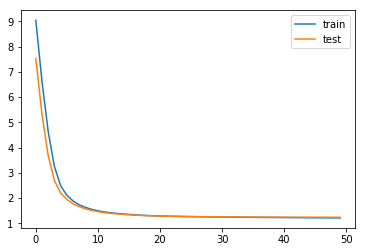

In [6]:
# Create Network with 100 neurons
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(999))
# Use custom loss ?
if not USE_CUSTOM_LOSS :
    func = 'mae'
else:
    func = weightedByBatch
    
# Compile
model.compile(loss=func, optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [7]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# calculate RMSE
rmse = sqrt(mean_squared_error(yhat, test_X))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.451


In [8]:
# Round values to get 0 or 1
rounded_pred = np.rint(yhat)
rounded_pred = np.absolute(rounded_pred)

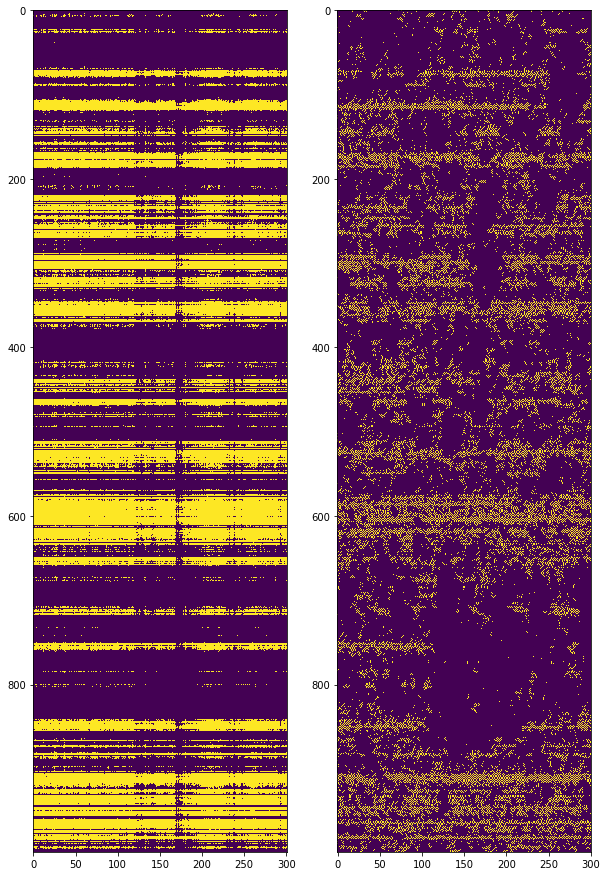

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(rounded_pred.T)


ax2 = fig.add_subplot(1,2,2)
ax2.imshow(test_X.T)






In [20]:
# Hamming distance
from scipy.spatial.distance import hamming
hamming_mat = np.zeros((301,))
for k in range(len(hamming_mat)):
    hamming_mat[k] = hamming(rounded_pred[k,:], test_X[k,:])

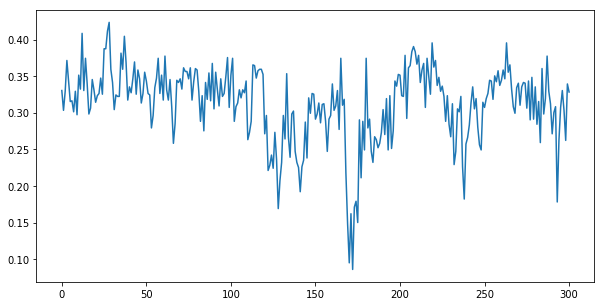

In [25]:
plt.figure(figsize=(10,5))
plt.plot(hamming_mat)
plt.show()

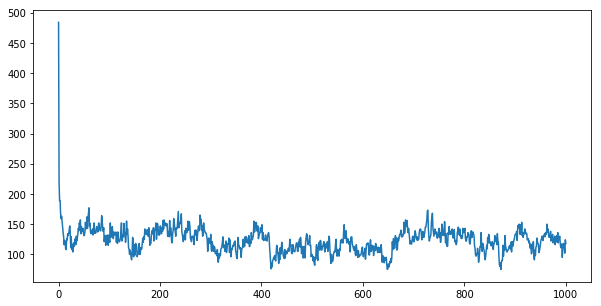

In [37]:
## Firing neurons over time
total_neuron = np.sum(neuron_data, axis = 1)
plt.figure(figsize=(10,5))
plt.plot(total_neuron)
plt.show()

In [38]:
total_neuron

array([484, 220, 189, ..., 102, 124, 118])